In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set_theme() # For heat map
from scipy.optimize import minimize # For automatic minimisation of the negative
# likelihood of the position
import numpy.random as rnd
import numpy.linalg as linalg
import matplotlib.path as mpltPath # to check if the point is on the border
from scipy.optimize import NonlinearConstraint
from ipynb.fs.full.class_virt_sensor import virt_sensor_net2
from ipynb.fs.full.class_ship import ship_fleet
from ipynb.fs.full.class_black_sea import black_sea_obj
%run ./strand2_methods.ipynb
%run ./class_black_sea.ipynb

Finish initialising class black_sea_obj


Finish initialising class black_sea_obj
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.007459438457315061
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 10
The average MSE over all lanes and repetitions is: 0.30830601438394856
The average MSE over all lanes and repetitions is: 0.003167484242759403
0.0007435644933882175


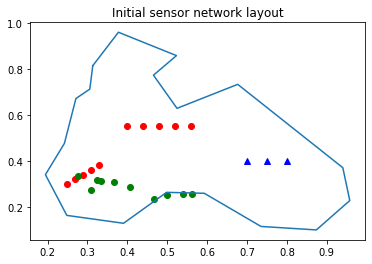

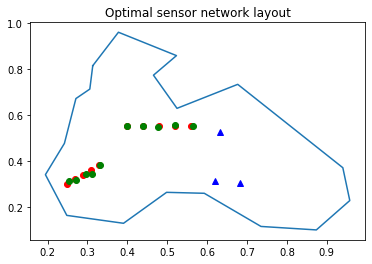

In [3]:
# MAIN SCRIPT ###############################



# Need to define the black sea object globally before loading the methods
black_sea_coords = np.load('blackSea_polygon_coords.npy')
global black_sea
black_sea = black_sea_obj(black_sea_coords)



# Setting istanbul at lower left corner (but let the method decide the concrete point
# by setting it as [0,0] (outside of area))
#black_sea.set_port('Istanbul', np.array([0,0]))


# Config

num_rep = 10 # Number of times each ship lane is repeated to obtain a mean prediction
time_stop = 5 # Time horizon for the ship movement
m = 3 # Number of sensors

# Define ships and their lanes by hand
ship_coords = np.array([.25, .3, .4, .55]).reshape(2,2)
ship_velocities = np.array([.02, .02, .04, 0]).reshape(2,2)
fleet = ship_fleet(ship_coords, ship_velocities, np.zeros(len(ship_coords)))

# Virtual sensor errors
err_mean = .05 # This error is the multiplicative value k in
# k*log(true_distance), and is used to define the standard deviation of a random 
# draw from N(0, k*log(true_distance)) that is added to the true_distance of a
# sensor to the ship
err_stdev = .5



# TESTING BFGS/SLSQP implementations

nlc = NonlinearConstraint(within_borders, 0, np.inf) # first argument is the
# contraint f(x) while second and third argument define c_1 < f(x) < c_2 where
# +-np.inf is a valid optim; IDEA FOR IMPLEMENTATION: give +-1 if it is (outside)
# within borders and use "0, np.inf" as arguments

# Fixed initial network
sensor_coords_0 = np.array([.75, .4, .7, .4, .8, .4]) # TRIAL as vector implementation
# NOTE: The bounds are used to concentrate the optimisation further into the relevant area for
# quicker convergence; the non-linear constraint (nlc) defines the actual borders
bnds = (((0,1),) * 2*m) # Need to define 2m bounds for each element of the variable vector
# NOTE: 'ftol' is the termination tolerance w.r.t. the gradient at the points (since we want to minimise)
res = minimize(MSE_loss, sensor_coords_0, method = 'SLSQP', jac = pseudo_MSE_loss_gradient,
               bounds = bnds, constraints = nlc, options={'ftol': 1e-10, 'maxiter': 200, 'disp': True})
opt_sensor_coords = res.x


# TESTING COBYLA
# NOTE: COBYLA does not use the jacobian
'''
res = minimize(MSE_loss, sensor_coords_0, method = 'COBYLA', jac = pseudo_MSE_loss_gradient,
               bounds = bnds, constraints = nlc, options={'tol': 1e-4, 'maxfev': 200, 'disp': True})
'''

    
    
# TESTING implementation with BFGS algorithm

#sensor_coords_0 = rnd.uniform(.1, .4, size = (2*m)) # TRIAL as vector implementation

# Fixed initial network
'''
sensor_coords_0 = np.array([.4, .4, .7, .4, .8, .4]) # TRIAL as vector implementation
res = minimize(MSE_loss, sensor_coords_0, method = 'BFGS', jac = pseudo_MSE_loss_gradient,
               options={'gtol': 1e-4, 'disp': True})
opt_sensor_coords = res.x
'''


# OLD VERSION: Sensor placement using Nelder-Mead
'''
# Gradient descent method for sensor placement
sensor_coords_0 = rnd.uniform(10,40,(m,2)) # Random first sensor placements
res = minimize(MSE_loss, sensor_coords_0, method='nelder-mead', 
               options={'disp': True})
opt_sensor_coords = res.x
'''




# First we plot the initial sensor placement and their mean predictions, followed
# by the "optimal placement" according to Nelson-Mead method w.r.t. MLE loss
# minimisation

# Testing BFGS/SLSQP implementations
MSE_loss_plot(sensor_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Initial sensor network layout")
MSE_loss_plot(opt_sensor_coords)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Optimal sensor network layout")


# FOR DEBUGGING: (Problem: SLSQP reported function value is very different that presented one)
print(MSE_loss(opt_sensor_coords))
# ANSWER: No problem in the code BUT rather the random gaussians that give the position estimates

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.37174388287276283
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0017381327754136748
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 8
Iteration limit reached    (Exit mode 9)
            Current function value: 0.0008430616623148889
            Iterations: 200
            Function evaluations: 232
            Gradient evaluations: 73
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0011016755039338325
            Iterations: 13
            Function evaluations: 102
            Gradient evaluations: 13
Iteration limit reached    (Exit mode 9)
            Current function value: 0.0010308414741963946
            Iterations: 200
            Function evaluations: 534

Text(0.5, 1.0, 'Best number optimal sensor network layout')

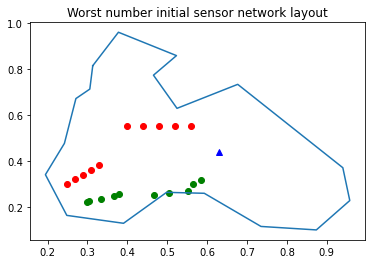

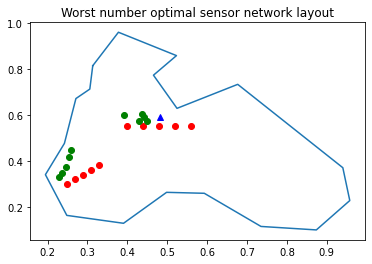

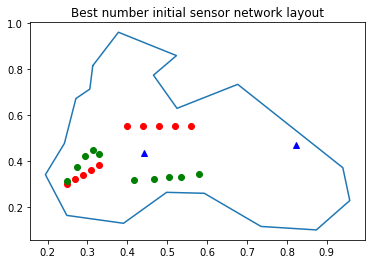

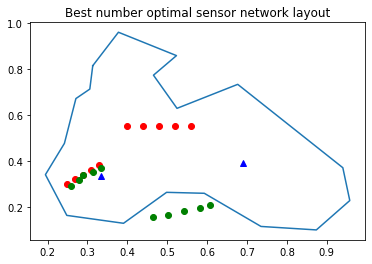

In [2]:
# TESTING optimal number of sensor placements

'''
# Define black sea object
black_sea_coords = np.load('/Users/marcelstozir/Desktop/IRP_sensorOptimisation/actual_work/code/simulation_of_simplified_sound_measures/definition_of_black_sea_borders/blackSea_polygon_coords.npy')
#plt.plot(black_sea_coords[:,0], black_sea_coords[:,1],'o')

black_sea = black_sea_obj(black_sea_coords)

# Setting istanbul at lower left corner (but let the method decide the concrete point
# by setting it as [0,0] (outside of area))
black_sea.set_port('Istanbul', np.array([0,0]))
'''


num_rep = 10 # Number of times each ship lane is repeated to obtain a mean prediction
time_stop = 5 # Time horizon for the ship movement

# Define ships and their lanes by hand
ship_coords = np.array([.25, .3, .4, .55]).reshape(2,2)
ship_velocities = np.array([.02, .02, .04, 0]).reshape(2,2)
fleet = ship_fleet(ship_coords, ship_velocities, np.zeros(len(ship_coords)))

# Virtual sensor errors
err_mean = .05 # This error is the multiplicative value k in
# k*log(true_distance), and is used to define the standard deviation of a random 
# draw from N(0, k*log(true_distance)) that is added to the true_distance of a
# sensor to the ship
err_stdev = .5


nlc = NonlinearConstraint(within_borders, 0, np.inf) # first argument is the
# contraint f(x) while second and third argument define c_1 < f(x) < c_2 where
# +-np.inf is a valid optim; IDEA FOR IMPLEMENTATION: give +-1 if it is (outside)
# within borders and use "0, np.inf" as arguments

best_number, worst_number, log_book = get_optimal_sensor_number(10)



# PLOT

# Testing optimal number of sensors

# Worst number; initial and optimal plot
m = worst_number
worst_coords_0 = log_book[0][worst_number - 1]
worst_coords_opt = log_book[1][worst_number - 1]
MSE_loss_plot(worst_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number initial sensor network layout")
MSE_loss_plot(worst_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number optimal sensor network layout")

# Best number; initial and optimal plot
m = best_number
best_coords_0 = log_book[0][best_number - 1]
best_coords_opt = log_book[1][best_number - 1]
MSE_loss_plot(best_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number initial sensor network layout")
MSE_loss_plot(best_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number optimal sensor network layout")

The average MSE over all lanes and repetitions is: 0.2301228563727549
The average MSE over all lanes and repetitions is: 0.033804697000929224
The average MSE over all lanes and repetitions is: 0.08182179283440036
The average MSE over all lanes and repetitions is: 0.0005920575389201516


Text(0.5, 1.0, 'Best number optimal sensor network layout')

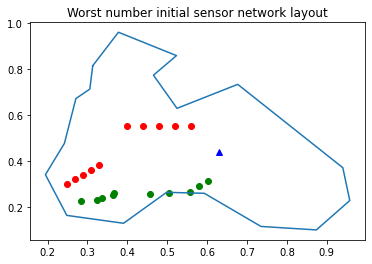

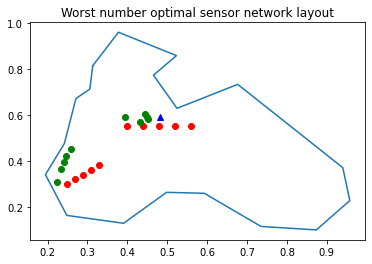

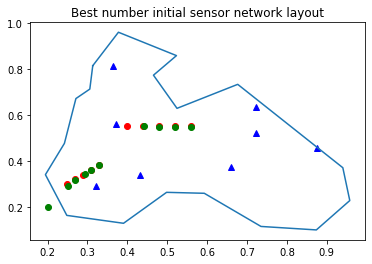

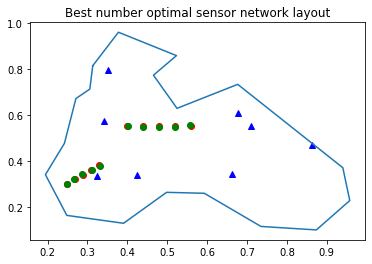

In [6]:
# NOTE: The optimal number of sensors is currently mostly through "lucky" Gaussian draws and not based
# on the actual layout (since the same layout has highly variable MSE_losses for subsequent calculations);
# ADDITIONALLY: The model selection method (currently with penalising term lambda*number_sensors) penalises
# complex systems too much - IDEA (for next version): Weight both, the MSE_loss and complexity, using lambda, 
# (1-lambda) after "standardising" them using some *1/(general_loss + general_complexity)
# THEREFORE: Need to implement strand 1 kalman filtering method before the optimisation procedure is viable

# Testing optimal number of sensors

# Worst number; initial and optimal plot
m = worst_number
worst_coords_0 = log_book[0][worst_number - 1]
worst_coords_opt = log_book[1][worst_number - 1]
MSE_loss_plot(worst_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number initial sensor network layout")
MSE_loss_plot(worst_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number optimal sensor network layout")

# Best number; initial and optimal plot
# BASED ON PURE OPTIMISATION VALUES: m = 8 is the best number
best_number = 8
m = best_number
best_coords_0 = log_book[0][best_number - 1]
best_coords_opt = log_book[1][best_number - 1]
MSE_loss_plot(best_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number initial sensor network layout")
MSE_loss_plot(best_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number optimal sensor network layout")